# Open Ocean
# Open Earth Fundation

<h1> Step 2: calculate different metrics for each modulating factor </h1>

This notebook is the second part of the `Step1_Curate_IUCN_RedList.ipynb`

<h2> Modulating Factor 1: Normalize Biodiversity Score </h2>

Species diversity refers to the variety of different species present in a given area, as well as their abundance and distribution. This includes the number of species, their relative abundances, and how evenly or unevenly distributed they are.
Our proposal is: apply the Simpson and Shannon Index to obtain a local value of the MPA and normalize each sqd km value

### Data needed for this project

- Species names
- Species abundance
- Species distribution

Next Steps:

1. Find a database or datasets with abundance and distribution information for the entire ACMC
2. If it isn't reallistic, try to simulate that data

Options:
1. IUCN RED List and simulate abundance information
2. GBIF species information and simulate abundance and distribution information

### 1. Importing libraries

In [1]:
# load basic libraries
import os
import glob
import boto3

import math
import random
import numpy as np
import pandas as pd

# to plot
import matplotlib.pyplot as plt

# to manage shapefiles
import shapely
import geopandas as gpd
from shapely.geometry import Polygon, Point, box
from shapely.ops import linemerge, unary_union, polygonize

In [2]:
import fiona; #help(fiona.open)

**Import OEF functions**

In [3]:
%load_ext autoreload

In [4]:
#Run this to reload the python file
%autoreload 2
from MBU_utils import *

### 2. Load data

In [5]:
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

In [ ]:
%%time
df = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp')

In [ ]:
%%time
#Locally
df = gpd.read_file('/Users/maureenfonseca/Desktop/Data-Oceans/ACMC_IUCN_data/gdf_ACMC_IUCN_range_status_filtered.shp')

In [6]:
grid = create_grid(ACMC, grid_shape="hexagon", grid_size_deg=0.5)

### 3. Preliminary calculations


**Shannon Index**

$\text{H} = -\sum[{p_i}\times\ln(p_i)]$


where, pi is the proportion of the entire community made up of species i

$p_i = {n/N}$

In [ ]:
def shannon(gdf_abundance_col):
    """
    Calculates the value of H using the given values of abundance.
    
    Parameters:
        - gdf_abundance_col (list): A list of species of the entire community made up of each species
        
    Returns:
        - H (float): The calculated value of H
    """
    
    abundance = np.array(gdf_abundance_col)
    N = np.sum(abundance)
    
    p = (abundance/N)
    
    H = 0
    for pi in p:
        if pi > 0:
            H += pi * math.log(pi)
    H = -H
    return H

In [ ]:
fake_abundance = np.random.randint(50, size = (len(df)))

In [ ]:
df['abundance'] = fake_abundance

In [ ]:
def shannon(roi, gdf, grid_gdf, gdf_col_name):
    """
    This function calculates the Shannon Index per grid cell and its corresponding MBU value
    pi = (n/N): where n is the abundance number per species and N is the total abundance number in the dataset 
    
    input(s):
    roi <shapely polygon in CRS WGS84:EPSG 4326>: region of interest or the total project area
    gdf <geopandas dataframe>: contains at least the name of the species, the distribution polygons of each of them 
                             :and their abundance
    grid_gdf <geopandas dataframe>: consists of polygons of grids typically generated by the gridding function
                                  : containts at least a geometry column and a unique grid_id
    gdf_col_name <string>: corresponds to the name of the abundance information column in the gdf
    
    output(s):
    gdf <geopandas dataframe>: with an additional column ('mbu_habitat_survey') containing the number
                             : of units for that grid or geometry
    """
    
    #Join in a gdf all the geometries within ROI
    gdf = gpd.clip(gdf.set_crs(epsg=4326, allow_override=True), roi)

    #This function calculates the sum of all abundances of overlapping species
    overlap = map_algebra(gdf, gdf_col_name, 'sum')

    #Merged the overlap values of overlapping geometries with the grid gdf
    merged = gpd.sjoin(overlap, grid_gdf, how='left')
    merged['n_value'] = overlap['algebra_overlaps']
    
    #Calculate the pi value per row
    pi = merged['n_value']/np.sum(merged['n_value'])
    pi = pi.fillna(0)
    merged['pilogpi'] = pi*np.log(pi)

    #Dissolve the DataFrame by 'index_right' and aggregate using the calculated Shannon entropy
    dissolve = merged.dissolve(by="index_right", aggfunc={'pilogpi': 'sum'})
    
    #Calculate the Shannon index per grid
    dissolve['pilogpi'] = (-1)*dissolve['pilogpi']

    #Put this into cell
    grid_gdf.loc[dissolve.index, 'Shannon'] = dissolve.pilogpi.values

    #Normalization factor
    Norm_factor = grid_gdf['Shannon']/grid_gdf['Shannon'].max()
    
    return grid_gdf

In [ ]:
Shannon = shannon(ACMC, df, grid, 'abundance')

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))

ax.set_aspect('equal')
Shannon.plot(ax = ax, column = 'Shannon', cmap = 'viridis', edgecolor = 'grey', linewidth = 0.01)

plt.show()

**OBIS data**

In [7]:
from pyobis import occurrences

In [8]:
#create a polygon to access the OBIS data
min_x, min_y, max_x, max_y = ACMC.total_bounds
geometry = f"POLYGON(({max_x} {min_y}, {min_x} {min_y}, {min_x} {max_y}, {max_x} {max_y}, {max_x} {min_y}))"

In [9]:
query = occurrences.search(geometry=geometry)
query.execute()

Fetching: [████████████████████████████████████████████████████████████████████████████████████████████████████] 4216/4216
Fetched 4216 records.


,rightsHolder,infraphylum,country,date_year,scientificNameID,scientificName,individualCount,dropped,gigaclassid,aphiaID,...,sectionid,subsectionid,minimumElevationInMeters,maximumElevationInMeters,hab,varietyid,variety,parvorder,parvorderid,associatedMedia
0,CAS,Gnathostomata,Costa Rica,1998.0,urn:lsid:marinespecies.org:taxname:293586,Doryrhamphus excisus excisus,1,False,10194.0,293586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIO,Gnathostomata,NaN,1967.0,urn:lsid:marinespecies.org:taxname:306621,Scopelogadus bispinosus,NaN,False,10194.0,306621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KU,Gnathostomata,Costa Rica,1954.0,urn:lsid:marinespecies.org:taxname:125636,Gymnothorax,NaN,False,10194.0,125636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Gnathostomata,NaN,NaN,urn:lsid:marinespecies.org:taxname:105857,Mobula birostris,NaN,False,NaN,1026118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAS,Gnathostomata,Panama,1956.0,urn:lsid:marinespecies.org:taxname:276587,Polydactylus approximans,2,False,10194.0,276587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4211,NaN,Gnathostomata,Costa Rica,1975.0,urn:lsid:marinespecies.org:taxname:276587,Polydactylus approximans,NaN,False,10194.0,276587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,NaN,Gnathostomata,NaN,NaN,urn:lsid:marinespecies.org:taxname:127401,Diodon eydouxii,NaN,False,10194.0,127401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4213,LACM,Gnathostomata,Costa Rica,1964.0,urn:lsid:marinespecies.org:taxname:276400,Dactyloscopus lacteus,1,False,10194.0,276400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4214,NaN,Gnathostomata,NaN,1925.0,NaN,Idiacanthus antrostomus,1,False,10194.0,275151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Returns the data
obis = query.data 

In [11]:
# convert OBIS dataframe to geodataframe
obis = gpd.GeoDataFrame(obis, 
                       geometry=gpd.points_from_xy(obis.decimalLongitude, 
                                          obis.decimalLatitude))

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [ ]:
fake_abundance = [random.randint(1, 100) for _ in range(len(obis))]
obis['abundance'] = fake_abundance

<AxesSubplot:>

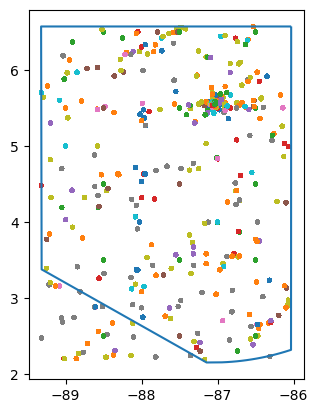

In [17]:
# plot protected area with marine species
# select column name to plot
column_name = 'scientificName'
ax = ACMC.boundary.plot()
obis.plot(ax=ax, markersize=5, column=column_name, 
        antialiased=False, legend_kwds={'bbox_to_anchor': (1, 1)})

In [18]:
#Join in a gdf all the geometries within ACMC
df2 = gpd.clip(obis.set_crs(epsg=4326, allow_override=True), ACMC)

In [19]:
#Spatial join of gdf and grid_gdf
pointInPolys = sjoin(df2, grid, how='inner')

'individualCount' refers to the number of individual organisms observed or sampled for a particular species at a particular location and time.

In [52]:
pointInPolys = pointInPolys.dropna(subset='individualCount')
pointInPolys['individualCount'] = pointInPolys['individualCount'].astype(float).astype(int)

In [54]:
N = pd.DataFrame()
N['N'] = pointInPolys.groupby('Grid_ID').apply(lambda x: x['individualCount'].sum())

In [55]:
new = pd.merge(pointInPolys, N, on='Grid_ID')

In [58]:
new['pi'] = new['individualCount']/new['N']
new['shannon'] = (-1)*new['pi']*np.log(new['pi'])

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [59]:
new = new.dissolve(by='Grid_ID', aggfunc={'shannon': 'sum'})

In [60]:
new = new.drop(['geometry'], axis = 1)

In [61]:
merge = new.merge(grid, how='right', on='Grid_ID')

In [71]:
merge = gpd.GeoDataFrame(merge)

In [79]:
def test(roi, gdf, grid_gdf):
    #Join in a gdf all the geometries within ACMC
    obis = gpd.clip(gdf.set_crs(epsg=4326, allow_override=True), roi)
    
    #Spatial join of gdf and grid_gdf
    pointInPolys = sjoin(obis, grid_gdf, how='inner')
    
    # 'individualCount' refers to the number of individual organisms observed or sampled 
    # for a particular species at a particular location and time.
    pointInPolys = pointInPolys.dropna(subset='individualCount')
    pointInPolys['individualCount'] = pointInPolys['individualCount'].astype(float).astype(int)
    
    #To calculate the total number of species
    N = pd.DataFrame()
    N['N'] = pointInPolys.groupby('Grid_ID').apply(lambda x: x['individualCount'].sum())
    
    new = pd.merge(pointInPolys, N, on='Grid_ID')
    
    #Calculate the Shanoon index with the information available
    new['pi'] = new['individualCount']/new['N']
    new['shannon'] = (-1)*new['pi']*np.log(new['pi'])
    
    new = new.dissolve(by='Grid_ID', aggfunc={'shannon': 'sum'})
    
    new = new.drop(['geometry'], axis = 1)
    
    merge = new.merge(grid, how='right', on='Grid_ID')
    
    grid_gdf = gpd.GeoDataFrame(merge)
    
    return grid_gdf

(-90.02200586479142,
 -85.62200586479142,
 1.4361630298765322,
 7.6282446669352675)

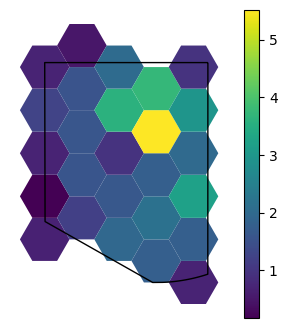

In [73]:
ax = df.plot(column='shannon', figsize=(4, 4), cmap='viridis', legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
ax.axis('off')

In [80]:
test(ACMC, obis, grid)

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Grid_ID,shannon,geometry
0,0,NaN,"POLYGON ((-88.82201 2.15063, -89.07201 2.58365..."
1,1,0.660915,"POLYGON ((-88.82201 3.01666, -89.07201 3.44967..."
2,2,0.173205,"POLYGON ((-88.82201 3.88268, -89.07201 4.31570..."
3,3,0.684616,"POLYGON ((-88.82201 4.74871, -89.07201 5.18172..."
4,4,1.247920,"POLYGON ((-88.82201 5.61474, -89.07201 6.04775..."
5,5,0.693147,"POLYGON ((-88.82201 6.48076, -89.07201 6.91377..."
6,6,NaN,"POLYGON ((-88.82201 7.34679, -89.07201 7.77980..."
7,7,NaN,"POLYGON ((-88.07201 1.71762, -88.32201 2.15063..."
8,8,NaN,"POLYGON ((-88.07201 2.58365, -88.32201 3.01666..."
9,9,1.184691,"POLYGON ((-88.07201 3.44967, -88.32201 3.88268..."
